In [46]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from layers import *
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import os

In [3]:
tf.enable_eager_execution()

In [4]:
z = tf.random_normal(shape=[100,100])

In [6]:
mnist = input_data.read_data_sets("./data/mnist", one_hot = True)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz


In [10]:
def show_images(images):
    if images.shape[3] == 3:
        
        c = images.shape[3]
        images = np.reshape(images, [images.shape[0], -1])
        sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1]/c)))
        fig = plt.figure(figsize = (7,7))
        gs = gridspec.GridSpec(sqrtn, sqrtn)
        gs.update(wspace = 0.05, hspace = 0.05)
    
        for i, img in enumerate(images):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg,c]))
    else:
        images = np.reshape(images, [images.shape[0], -1])
        sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
        fig = plt.figure(figsize = (7, 7))
        gs = gridspec.GridSpec(sqrtn, sqrtn)
        gs.update(wspace = 0.05, hspace = 0.05)
    
        for i, img in enumerate(images):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(img.reshape([sqrtimg,sqrtimg]), cmap = plt.cm.gray)
    return 
        
    

In [55]:
class LSGAN:
    
    def __init__(self,batch_size,training_epoch):
        self.batch_size = batch_size
        self.training_epoch = training_epoch
        self.learning_rate = 0.0002
        self.z_size = 100
        self.check_point_dir = 'check_point/LSGAN'
    
    def generator(self,z,is_train = True,reuse = True):
        with tf.variable_scope("generator", reuse = reuse):
            net = tf.nn.relu(dense(z, 1024,"g_1"))
            net = tf.nn.relu(bn(dense(net,7*7*128,"g_2"),is_train))
            net = tf.reshape(net, [100,7,7,128])
            net = tf.nn.relu(bn(conv_trans(net, 128,5,2,"g_3"),is_train))
            net = tf.nn.sigmoid(conv_trans(net, 1,5,2,"g_4"))
            return net
    
    def discriminator(self,x, is_train = True, reuse= True):
        with tf.variable_scope("discriminator", reuse = reuse):
            net = tf.nn.relu(conv(x,256,5,2,"d_1"))
            net = tf.nn.relu(bn(conv(net,320,5,2,"d_2"),is_train))
            net = tf.layers.flatten(net)
            net = tf.nn.relu(bn(dense(net,1024,"d_3"),is_train))
            net = dense(net,1,"d_4")
        return net
    
    def build_model(self):
        self.x = tf.placeholder(tf.float32, shape = [None, 784])
        self.z = tf.placeholder(tf.float32, shape = [None, self.z_size])
        self.x_img = tf.reshape(self.x , [self.batch_size, 28,28,1])
        
        
        g = self.generator(self.z, reuse = False)
        d_real = self.discriminator(self.x_img,reuse = False)
        d_fake = self.discriminator(g)
        
        self.sample_images = self.generator(self.z)
        # Define Loss
        d_real_loss = 0.5 * tf.reduce_mean(tf.square(d_real - 1.))
        d_fake_loss = 0.5 * tf.reduce_mean(tf.square(d_fake - 0.))
        self.d_loss = d_real_loss + d_fake_loss
        self.g_loss = 0.5 * tf.reduce_mean(tf.square(d_fake - 1.))
        
        # training variable
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if 'd_' in var.name]
        g_vars = [var for var in t_vars if 'g_' in var.name]
        
        # Define Optimizer
        self.d_trainer = tf.train.AdamOptimizer(learning_rate = self.learning_rate, 
                                                beta1 = 0.5).minimize(self.d_loss, var_list= d_vars)
        self.g_trainer = tf.train.AdamOptimizer(learning_rate= self.learning_rate,
                                               beta1 = 0.5).minimize(self.g_loss, var_list = g_vars)
        
        
    def train(self):
        self.build_model()
        mnist = input_data.read_data_sets('./data/mnist', one_hot = True)
        init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.sample_noise = np.random.uniform(-1,1,size =(self.batch_size,self.z_size))

        with tf.Session() as sess:
            sess.run(init)
            if not os.path.exists('./sample_images/LSGAN'):
                os.mkdir('./sample_images/LSGAN')
            
                
            for epoch in range(self.training_epoch):
                total_batch = int(mnist.train.num_examples / self.batch_size)
                
                for iteration in range(total_batch):
                    batch_xs, _ = mnist.train.next_batch(self.batch_size)
                    noise_z = np.random.uniform(-1, 1 ,[self.batch_size, self.z_size])
                    
                    _ , d_loss_val = sess.run([self.d_trainer, self.d_loss], feed_dict = {self.x : batch_xs, self.z : noise_z})
                    _ , g_loss_val = sess.run([self.g_trainer, self.g_loss], feed_dict = {self.z : noise_z})
                    
                
                print("Epoch : {} ,  D_loss : {},  G_loss : {} ".format(epoch, d_loss_val, g_loss_val))
                sample_images = sess.run(self.sample_images ,feed_dict = {self.z : self.sample_noise})
                show_images(sample_images)
                plt.savefig('./sample_images/LSGAN/{}.png'.format(str(epoch).zfill(3)), bbox_inches = 'tight')
                plt.show()
            self.save_model(sess,self.check_point_dir,epoch)

                
    def save_model(self,sess, check_point_dir, step):
        check_point_dir = os.path.join(check_point_dir,"cGAN_model")
        
        if not os.path.exists(check_point_dir):
            os.makedirs(check_point_dir)
        
        self.saver.save(sess, os.path.join(check_point_dir),global_step = step)
                
                    
        
        

            
    



In [56]:
tf.reset_default_graph()

In [57]:
a = LSGAN(100,10)

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Epoch : 0 ,  D_loss : 0.13010236620903015,  G_loss : 0.35470762848854065 


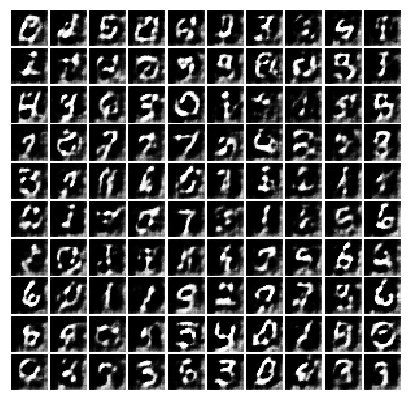

Epoch : 1 ,  D_loss : 0.08678554743528366,  G_loss : 0.347416490316391 


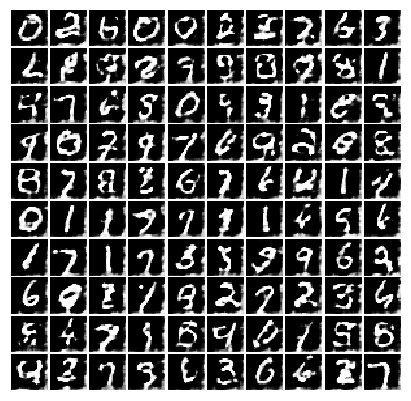

Epoch : 2 ,  D_loss : 0.10721535980701447,  G_loss : 0.3392777740955353 


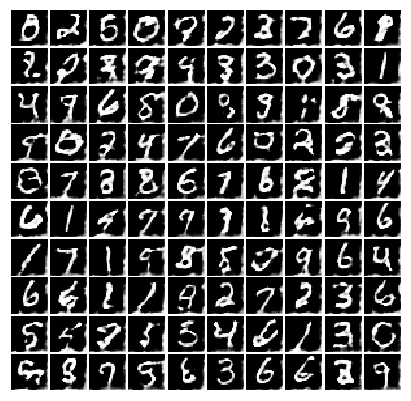

Epoch : 3 ,  D_loss : 0.0665414035320282,  G_loss : 0.40894973278045654 


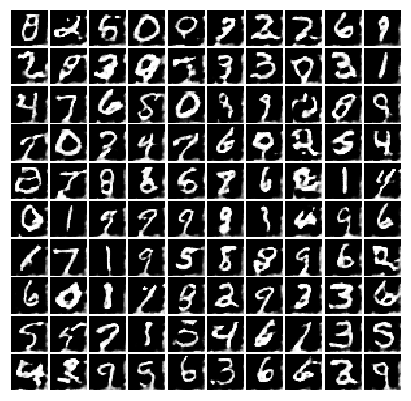

Epoch : 4 ,  D_loss : 0.0708853229880333,  G_loss : 0.39372050762176514 


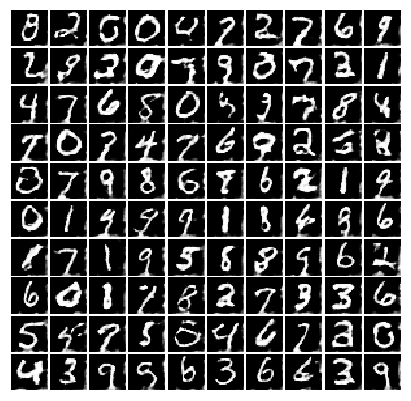

Epoch : 5 ,  D_loss : 0.06645136326551437,  G_loss : 0.4131443500518799 


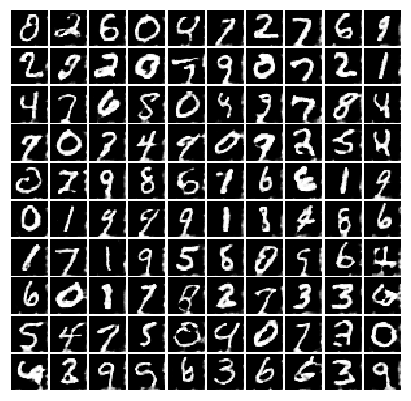

Epoch : 6 ,  D_loss : 0.06099686771631241,  G_loss : 0.3522467315196991 


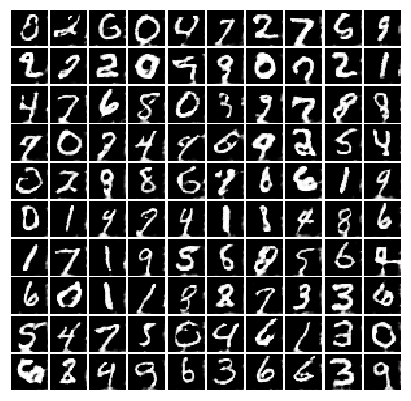

Epoch : 7 ,  D_loss : 0.03244047611951828,  G_loss : 0.5014895796775818 


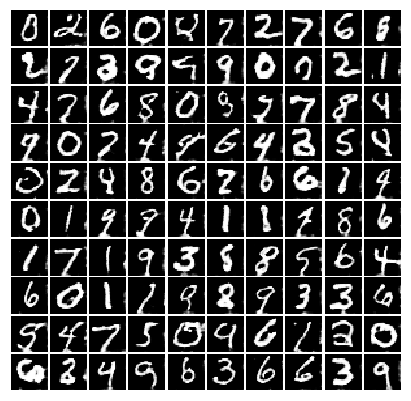

Epoch : 8 ,  D_loss : 0.050281643867492676,  G_loss : 0.5333348512649536 


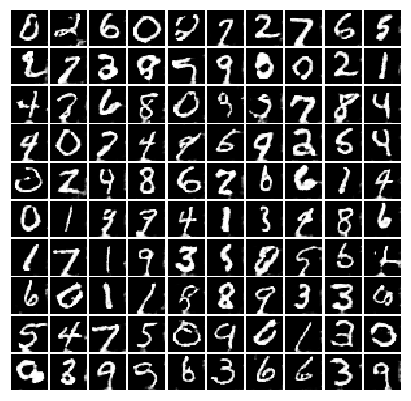

Epoch : 9 ,  D_loss : 0.032236579805612564,  G_loss : 0.4203924536705017 


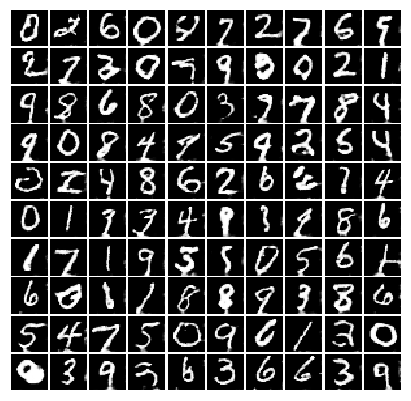

In [58]:
a.train()